> # Import  Libraries 

In [1]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


> #  Get & Adjust Data

In [2]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("archive/IDC_regular_ps50_idx5") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="archive/IDC_regular_ps50_idx5/"

### what is the structure of our data?

In [3]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

##### We can see 279 files for each patient named with their id, and each file contains x-ray images of its owner

### To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [4]:
# os.mkdir(all_rays_dir)

In [5]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [6]:
# #Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
# for patient in cancer_rays_dir:   
#     path_0 = cancer_rays_dir_str + str(patient) + '/0'
#     path_1 = cancer_rays_dir_str + str(patient) + '/1'
#     file_list_0 = os.listdir(path_0)   
#     file_list_1 = os.listdir(path_1)
#     for fname in file_list_0:
#             src = os.path.join(path_0, fname)
#             dst = os.path.join(all_rays_dir, fname)
#             shutil.copyfile(src, dst)
#     for fname in file_list_1:
#         src = os.path.join(path_1, fname)
#         dst = os.path.join(all_rays_dir, fname)
#         shutil.copyfile(src, dst)

In [7]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

277524

##### Now we have 277,524 images, what a number!

### Then, it's time to put images in a data_frame for easy access:

In [8]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()


image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [9]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [10]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0  10253_idx5_x1001_y1001_class0.png      0      10253
1  10253_idx5_x1001_y1051_class0.png      0      10253
2  10253_idx5_x1001_y1101_class0.png      0      10253
3  10253_idx5_x1001_y1151_class0.png      0      10253
4  10253_idx5_x1001_y1201_class0.png      0      10253

In [11]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

#### It also seems that the number of healthy rays is greater than the number of infected rays, good news!

> # Exploratory Data Analysis

#### First of all, let's take a look at the nature of the mammograms...

## Healthy patches:


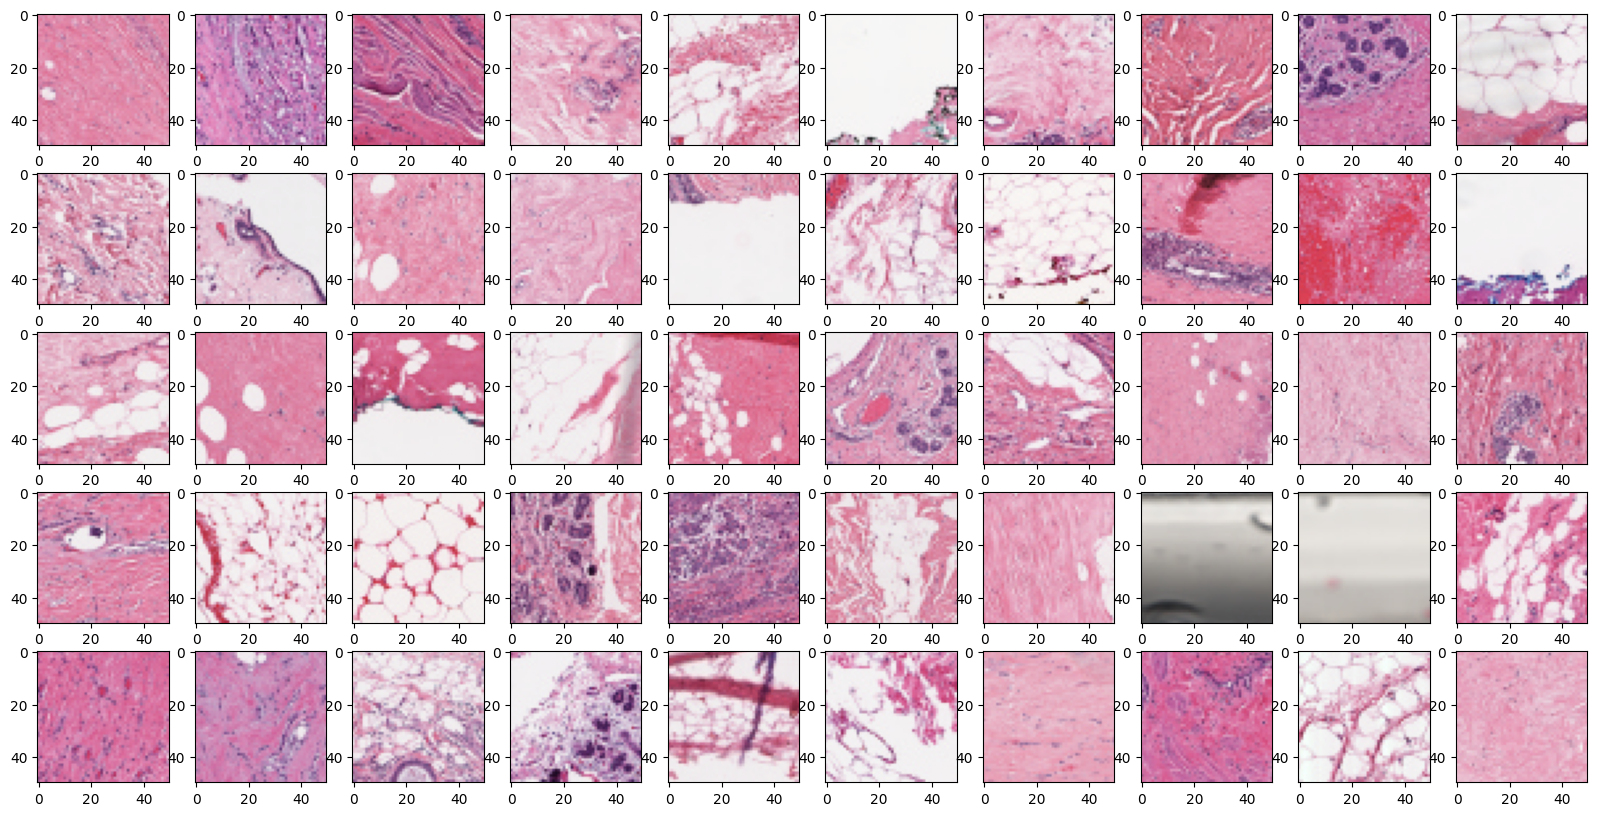

In [12]:
data.target = data.target.astype(int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights
- Most of the mammograms are light pink, but there are some dark ones too

# Cancer patches:

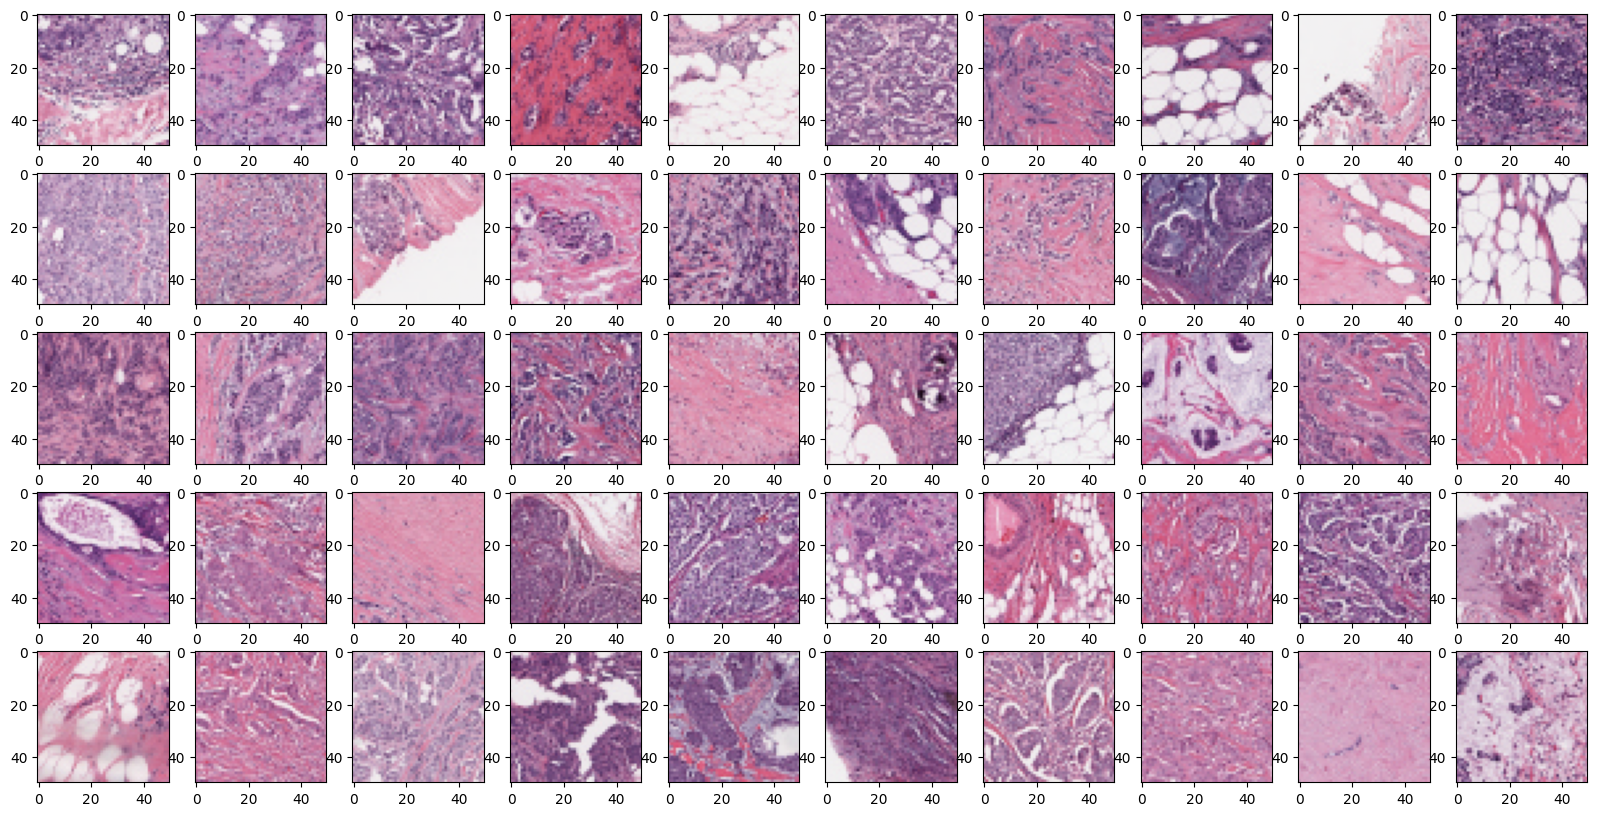

In [13]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

- Patches with cancer look more violet and crowded than healthy ones. 
- In fact, we could not determine the actual difference between the two types with the naked eye, but I think that the model is able to detect hidden patterns in these images that enable us to determine the state of each image.

### Let's ask some questions that will help us get to know more our data:
- do all patients have the same number of mammograms?
- what is the percentage of cancer (IDC) that each mammogram shows? 
- how many healthy and cancered mammograms are in the data?

C:\Users\dhanu\AppData\Local\Temp\ipykernel_20068\2848603386.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data.target, palette="Set2", ax=ax[2], discrete=True)


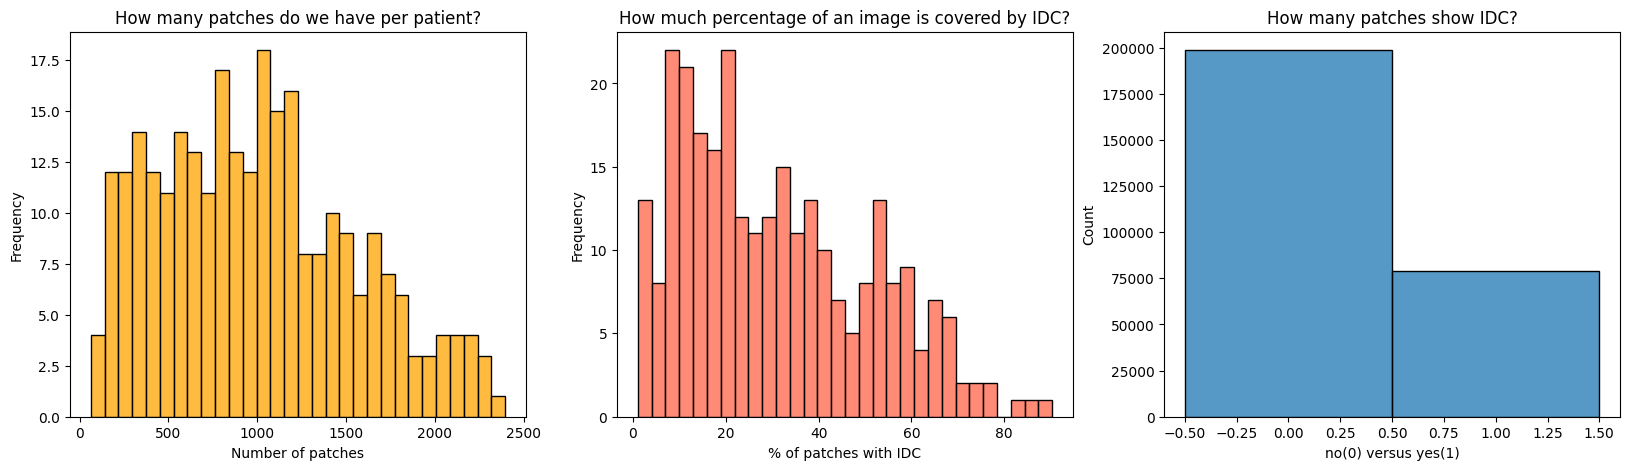

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

sns.histplot(data.target, palette="Set2", ax=ax[2], discrete=True)
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?")

plt.show()

In [15]:
# cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
# cancer_perc = cancer_perc.unstack()

# fig, ax = plt.subplots(1,3,figsize=(20,5))
# sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
# ax[0].set_xlabel("Number of patches")
# ax[0].set_ylabel("Frequency");
# ax[0].set_title("How many patches do we have per patient?");
# sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
# ax[1].set_title("How much percentage of an image is covered by IDC?")
# ax[1].set_ylabel("Frequency")
# ax[1].set_xlabel("% of patches with IDC");
# sns.countplot(data.target, palette="Set2", ax=ax[2]);
# ax[2].set_xlabel("no(0) versus yes(1)")
# ax[2].set_title("How many patches show IDC?");

### Insights:
- The number of image patches per patient varies a lot
- Most of the photos have a percentage that is not large, but there are other photos that have a percentage of up to 80%
- the smaller number of mammograms had cancer

In [16]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    print("Type of df_0:", type(df_0))
    print("Shape of df_0:", df_0.shape)
    
    df_1 = get_cancer_dataframe(patient_id, "1")
    print("Type of df_1:", type(df_1))
    print("Shape of df_1:", df_1.shape)
    
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df


In [17]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (479, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (70, 4)


x     y  target                                               path
0  1001  1001       0  archive/IDC_regular_ps50_idx5/10253/0/10253_id...
1  1001  1051       0  archive/IDC_regular_ps50_idx5/10253/0/10253_id...
2  1001  1101       0  archive/IDC_regular_ps50_idx5/10253/0/10253_id...
3  1001  1151       0  archive/IDC_regular_ps50_idx5/10253/0/10253_id...
4  1001  1201       0  archive/IDC_regular_ps50_idx5/10253/0/10253_id...

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (479, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (70, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (772, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (76, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (181, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (91, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (351, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (117, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (427, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (208, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (422, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (108, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (1434, 4)
Type of df_1: 

Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (1053, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (754, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (617, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (587, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (2086, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (23, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (904, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (250, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (2150, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (25, 4)
Type of df_0: <class 'pandas.core.frame.DataFrame'>
Shape of df_0: (811, 4)
Type of df_1: <class 'pandas.core.frame.DataFrame'>
Shape of df_1: (1211, 4)


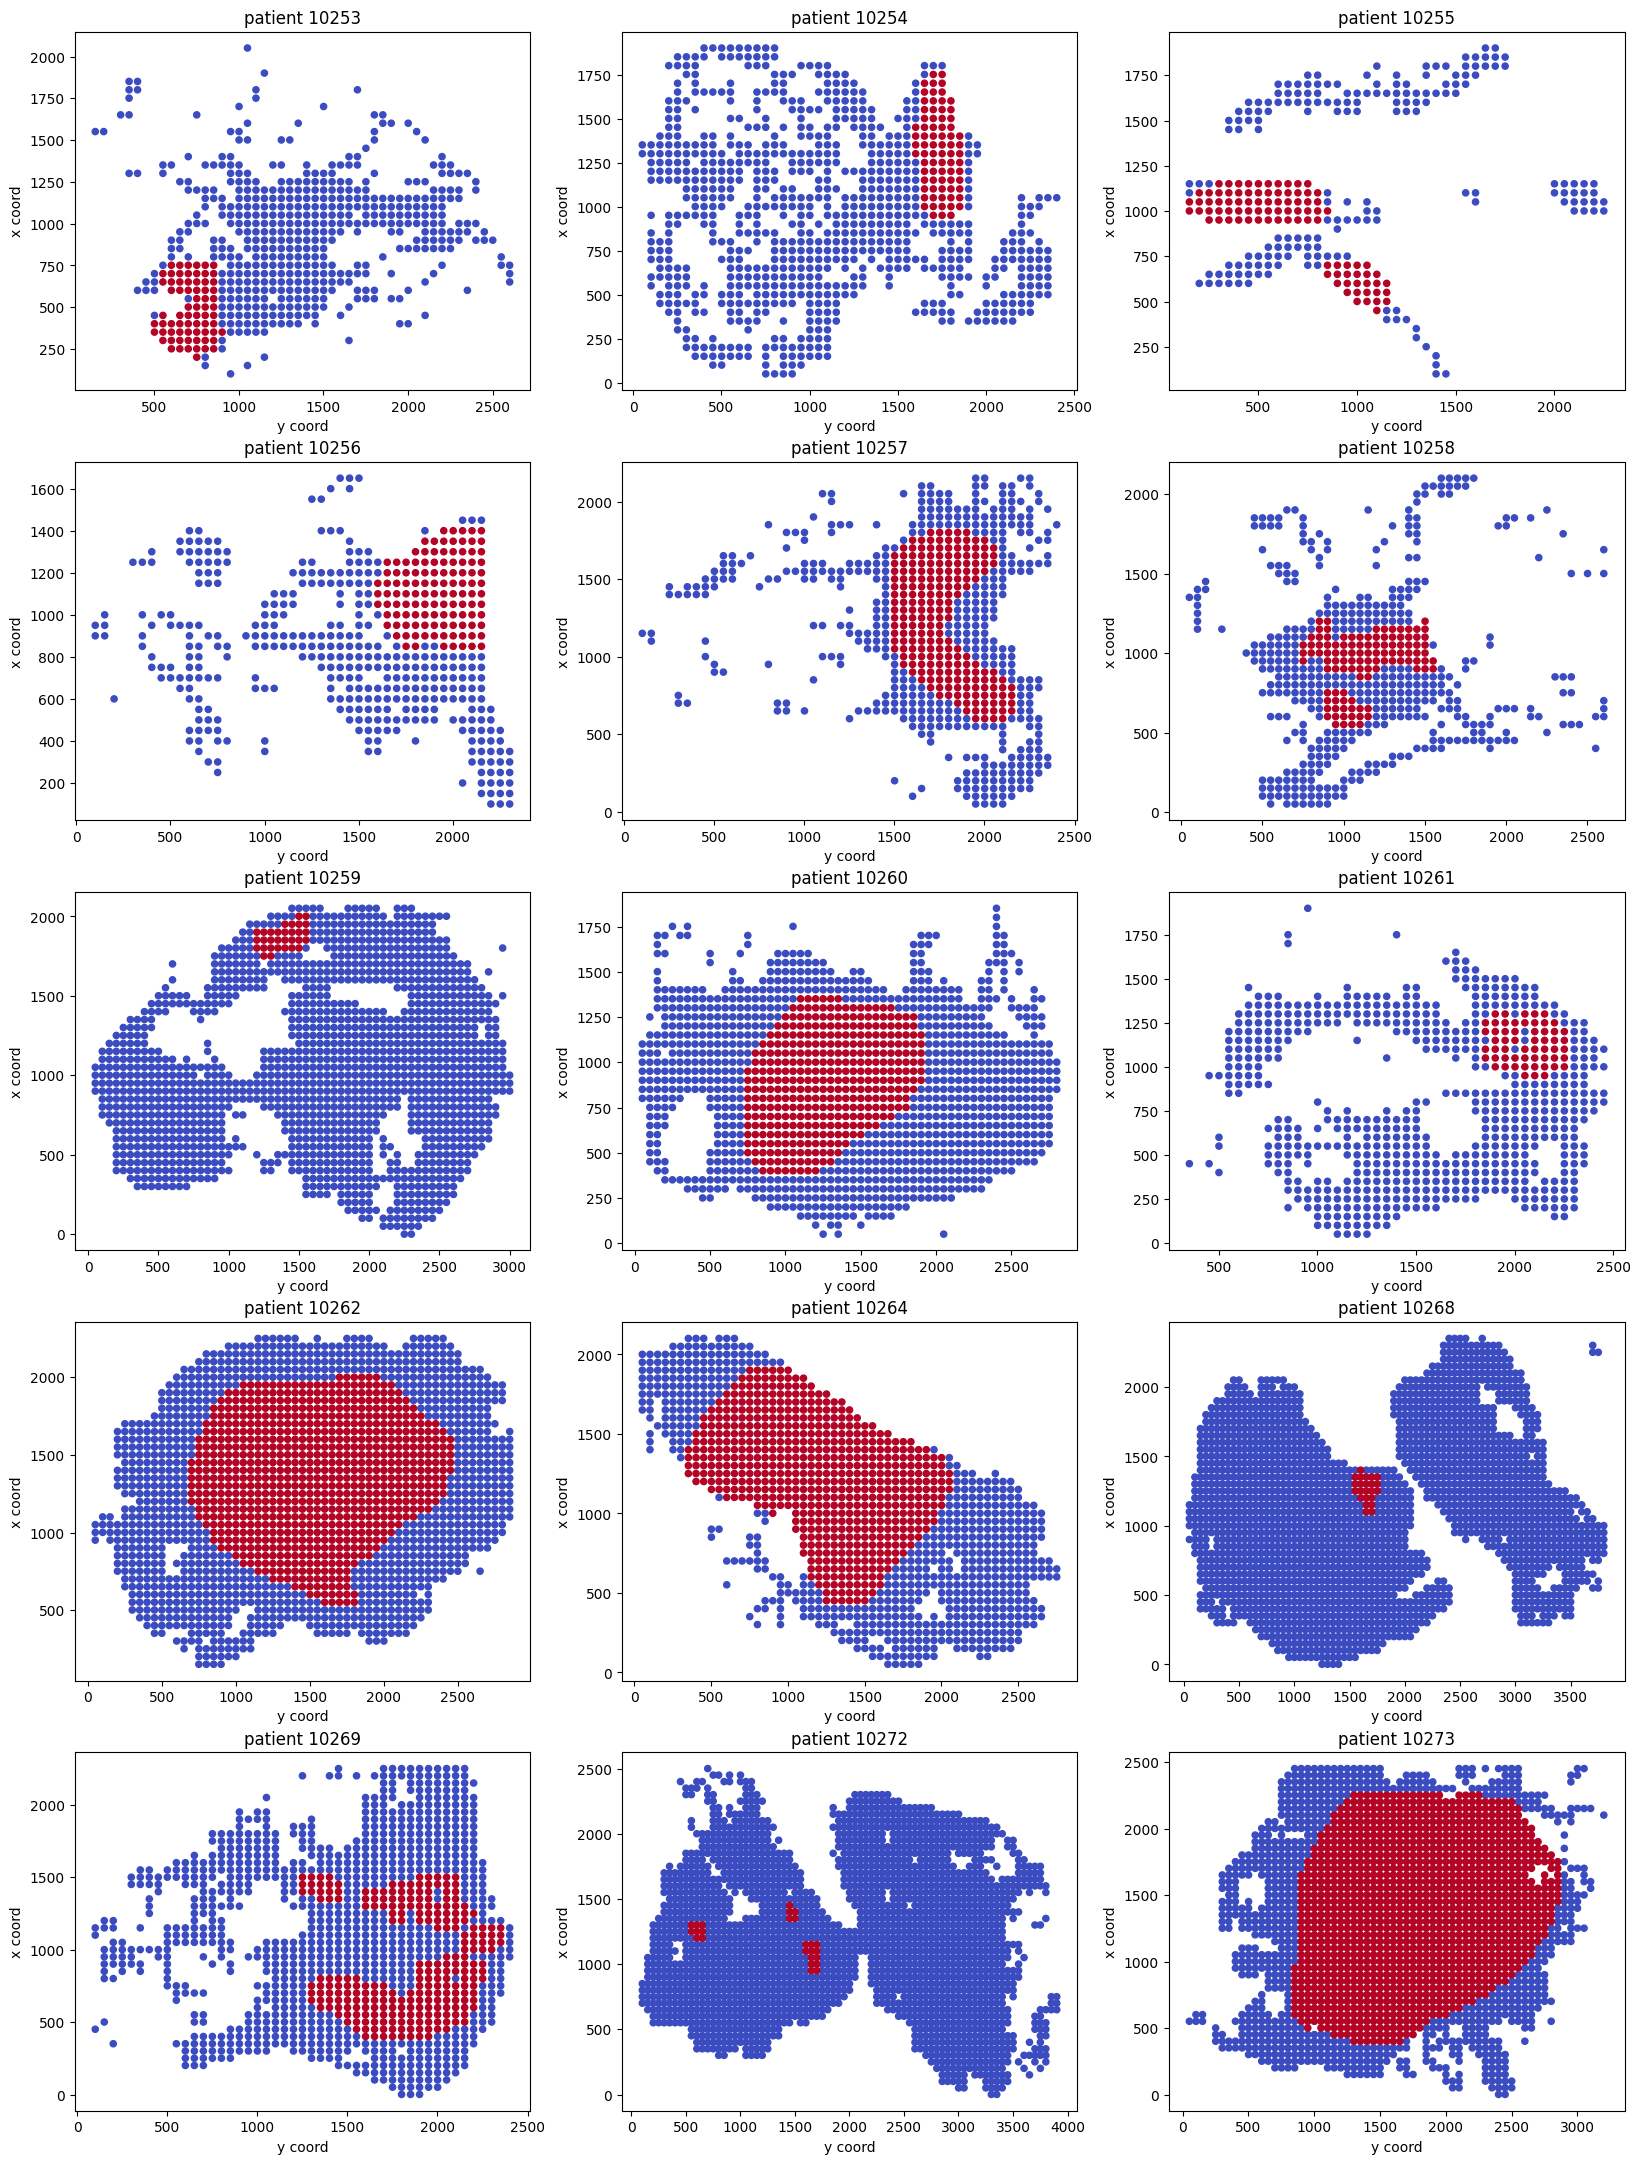

In [18]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights:

- We see a large variation in the concentration of cells
- Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

> # Processing and selection
it's time to work on our data..

# Image Processing 

-  Apply some processing properties

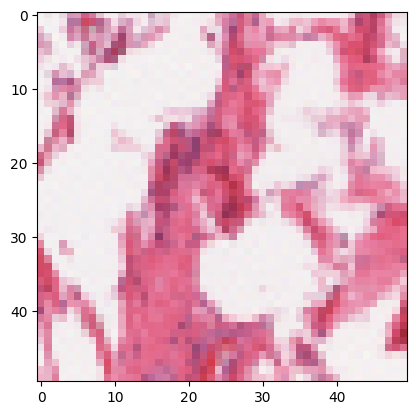

In [19]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

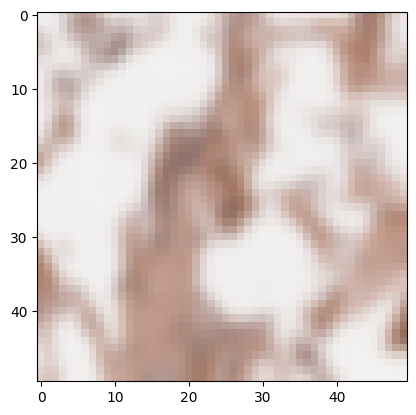

In [20]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

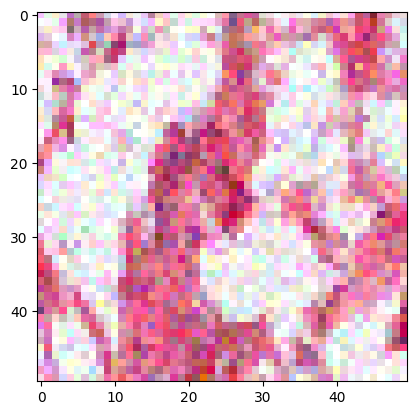

In [21]:
noise_image = random_noise(image)
plt.imshow(noise_image)

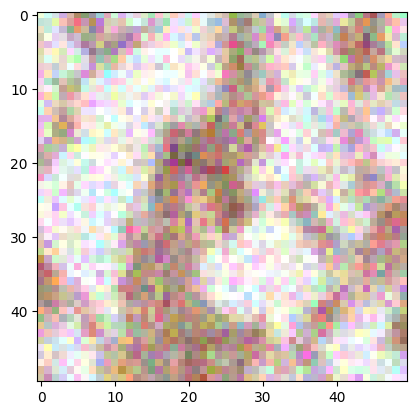

In [22]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

-  Processing using (random_noise) function

In [23]:
# os.mkdir('image_processing') #We create a new file to process the data in
# os.mkdir('image_processing/noise_images')

In [25]:
from PIL import Image

# Example code to read the image using PIL
path = 'all_rays_dir/10273_idx5_x351_y1501_class0.png'
try:
    img = Image.open(path)
    # Perform operations on the image if needed
except Exception as e:
    print("Error:", e)

Error: cannot identify image file 'all_rays_dir/10273_idx5_x351_y1501_class0.png'


In [28]:
#Here we take the image from the normal images folder, process it, and then save it in the new file
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)
    

In [ ]:
# os.mkdir( 'image_processing/processd_data_train')
# os.mkdir( 'image_processing/processd_data_test')
# os.mkdir( 'image_processing/processd_data_train/zeros')
# os.mkdir( 'image_processing/processd_data_train/ones')
# os.mkdir( 'image_processing/processd_data_test/zeros')
# os.mkdir( 'image_processing/processd_data_test/ones')


In [29]:

processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [30]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [31]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [32]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [33]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)


In [34]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [35]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


# Processing  and Normal test

-  the images we processed and the noraml are tested on the same model to see which the best in the accuracy

-  A small sample is taken for testing (20,000) images

### First: the processed images

In [36]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [37]:
# os.mkdir( 'image_processing/model_tst')
# os.mkdir( 'image_processing/model_tst/trainig')
# os.mkdir( 'image_processing/model_tst/testing')          
# os.mkdir( 'image_processing/model_tst/trainig/zeros')
# os.mkdir( 'image_processing/model_tst/trainig/ones')
# os.mkdir( 'image_processing/model_tst/testing/zeros')
# os.mkdir( 'image_processing/model_tst/testing/ones')

In [38]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


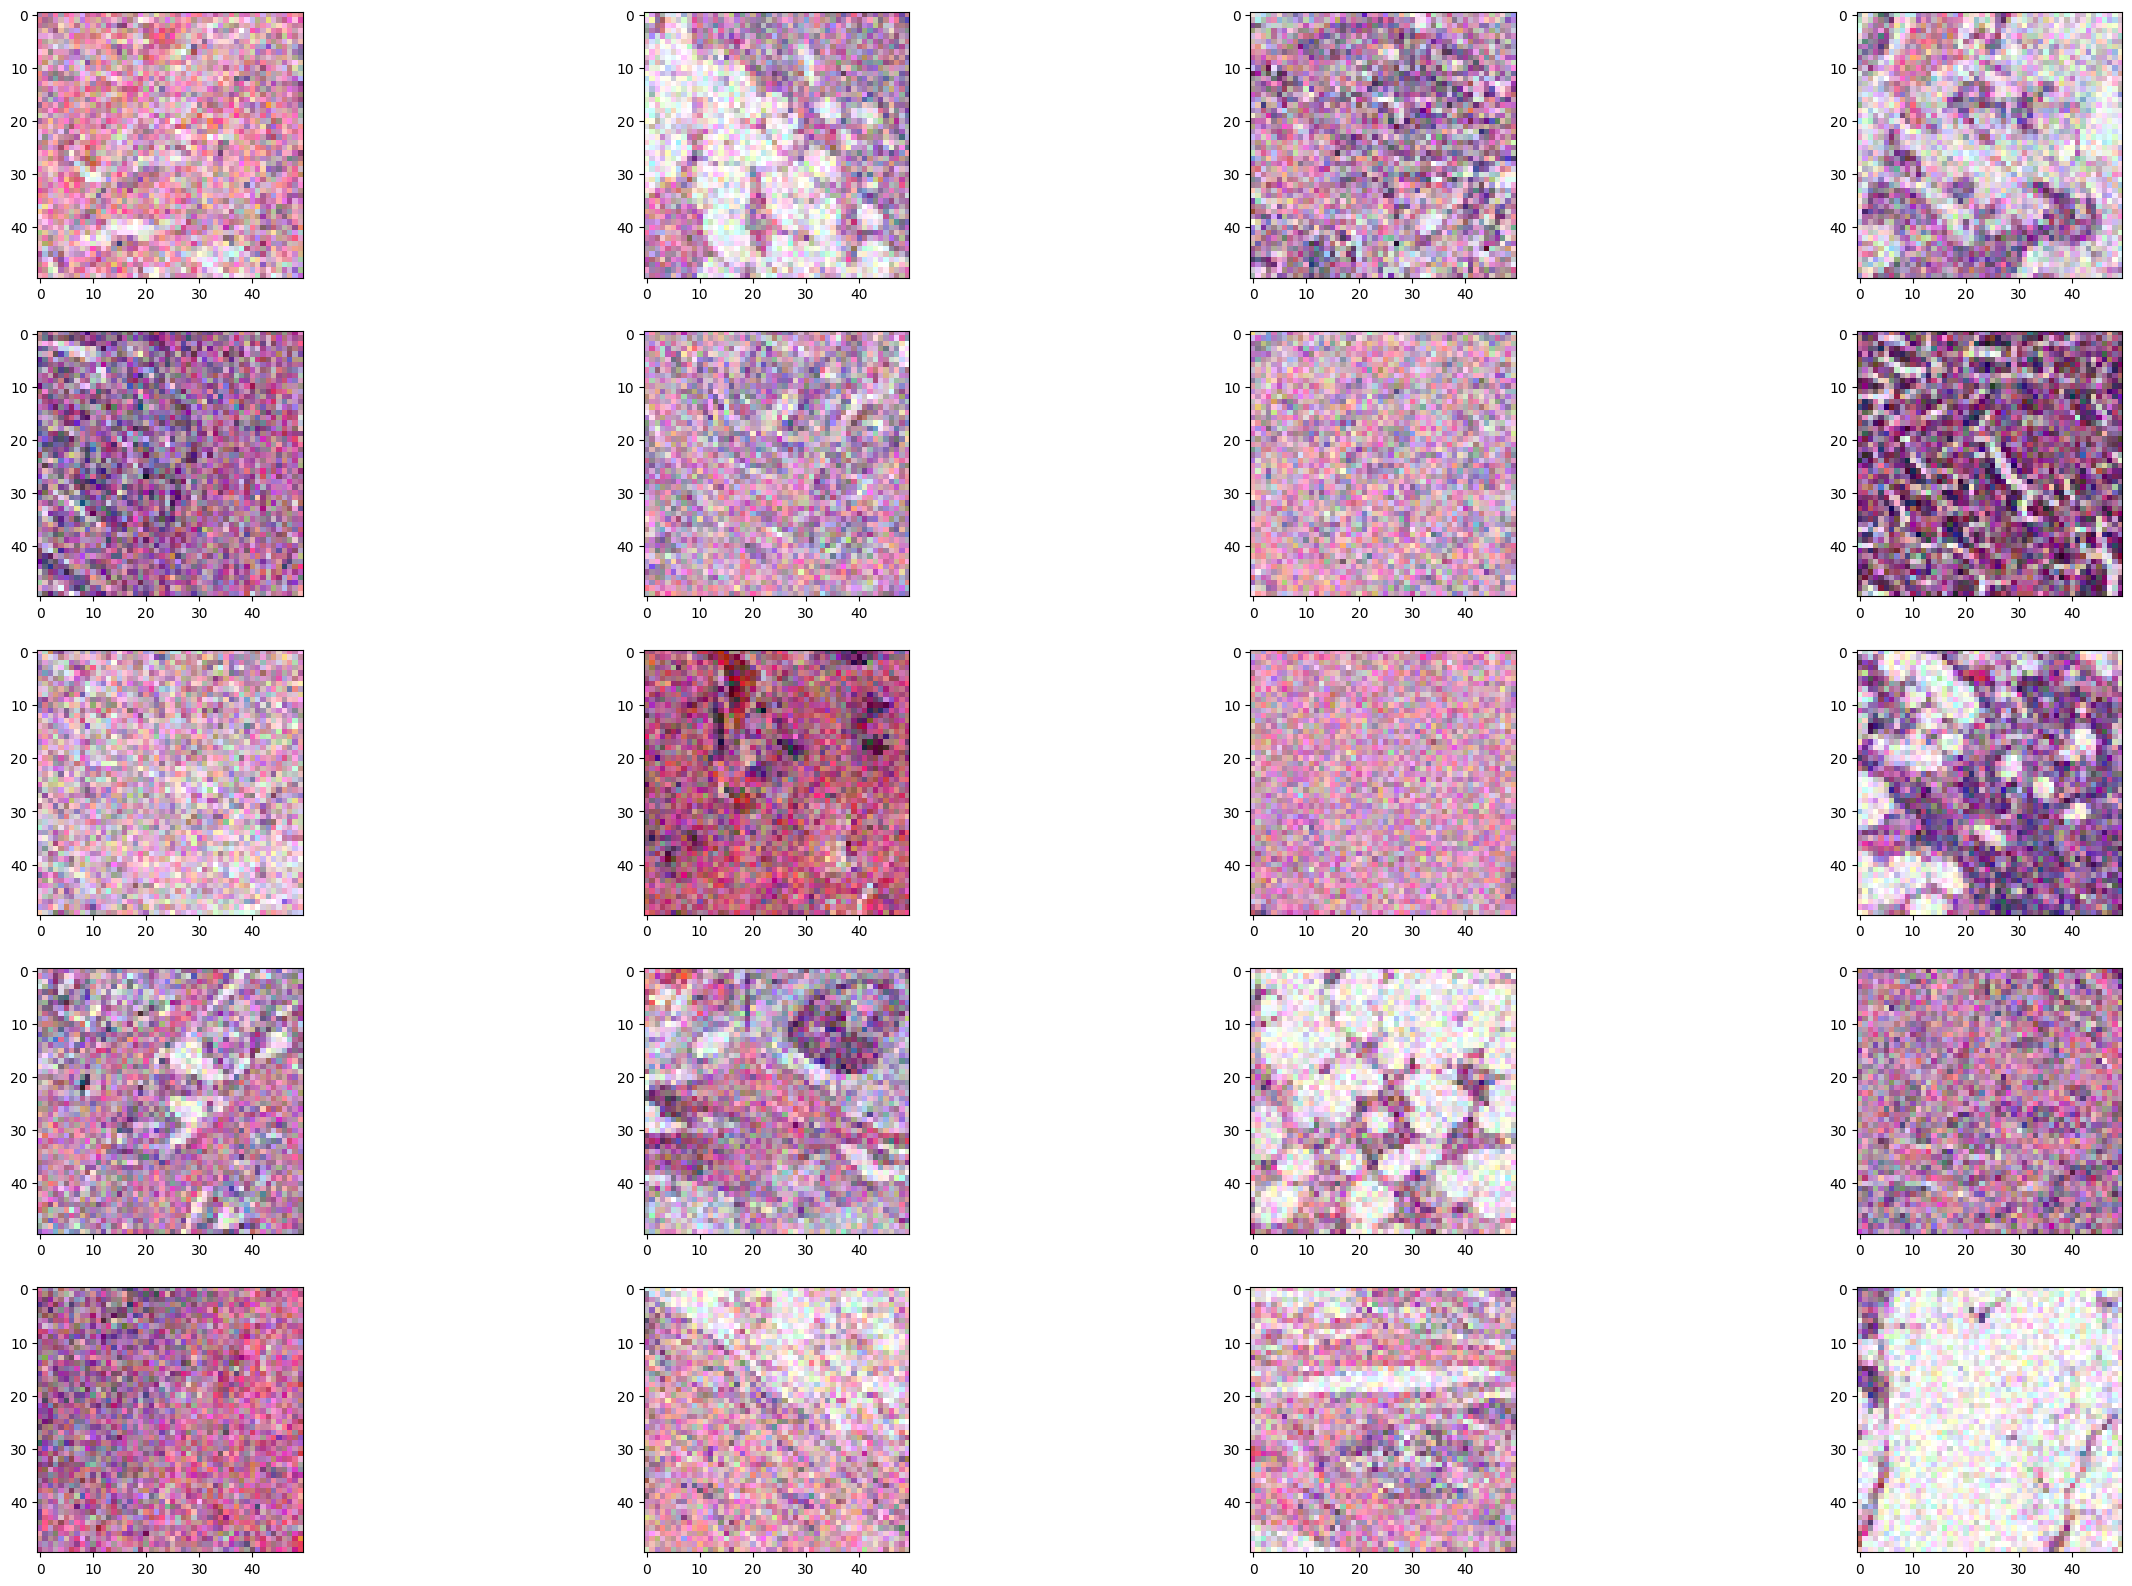

In [39]:
processd_data.target = processd_data.target.astype(int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the processed carcinogenic images

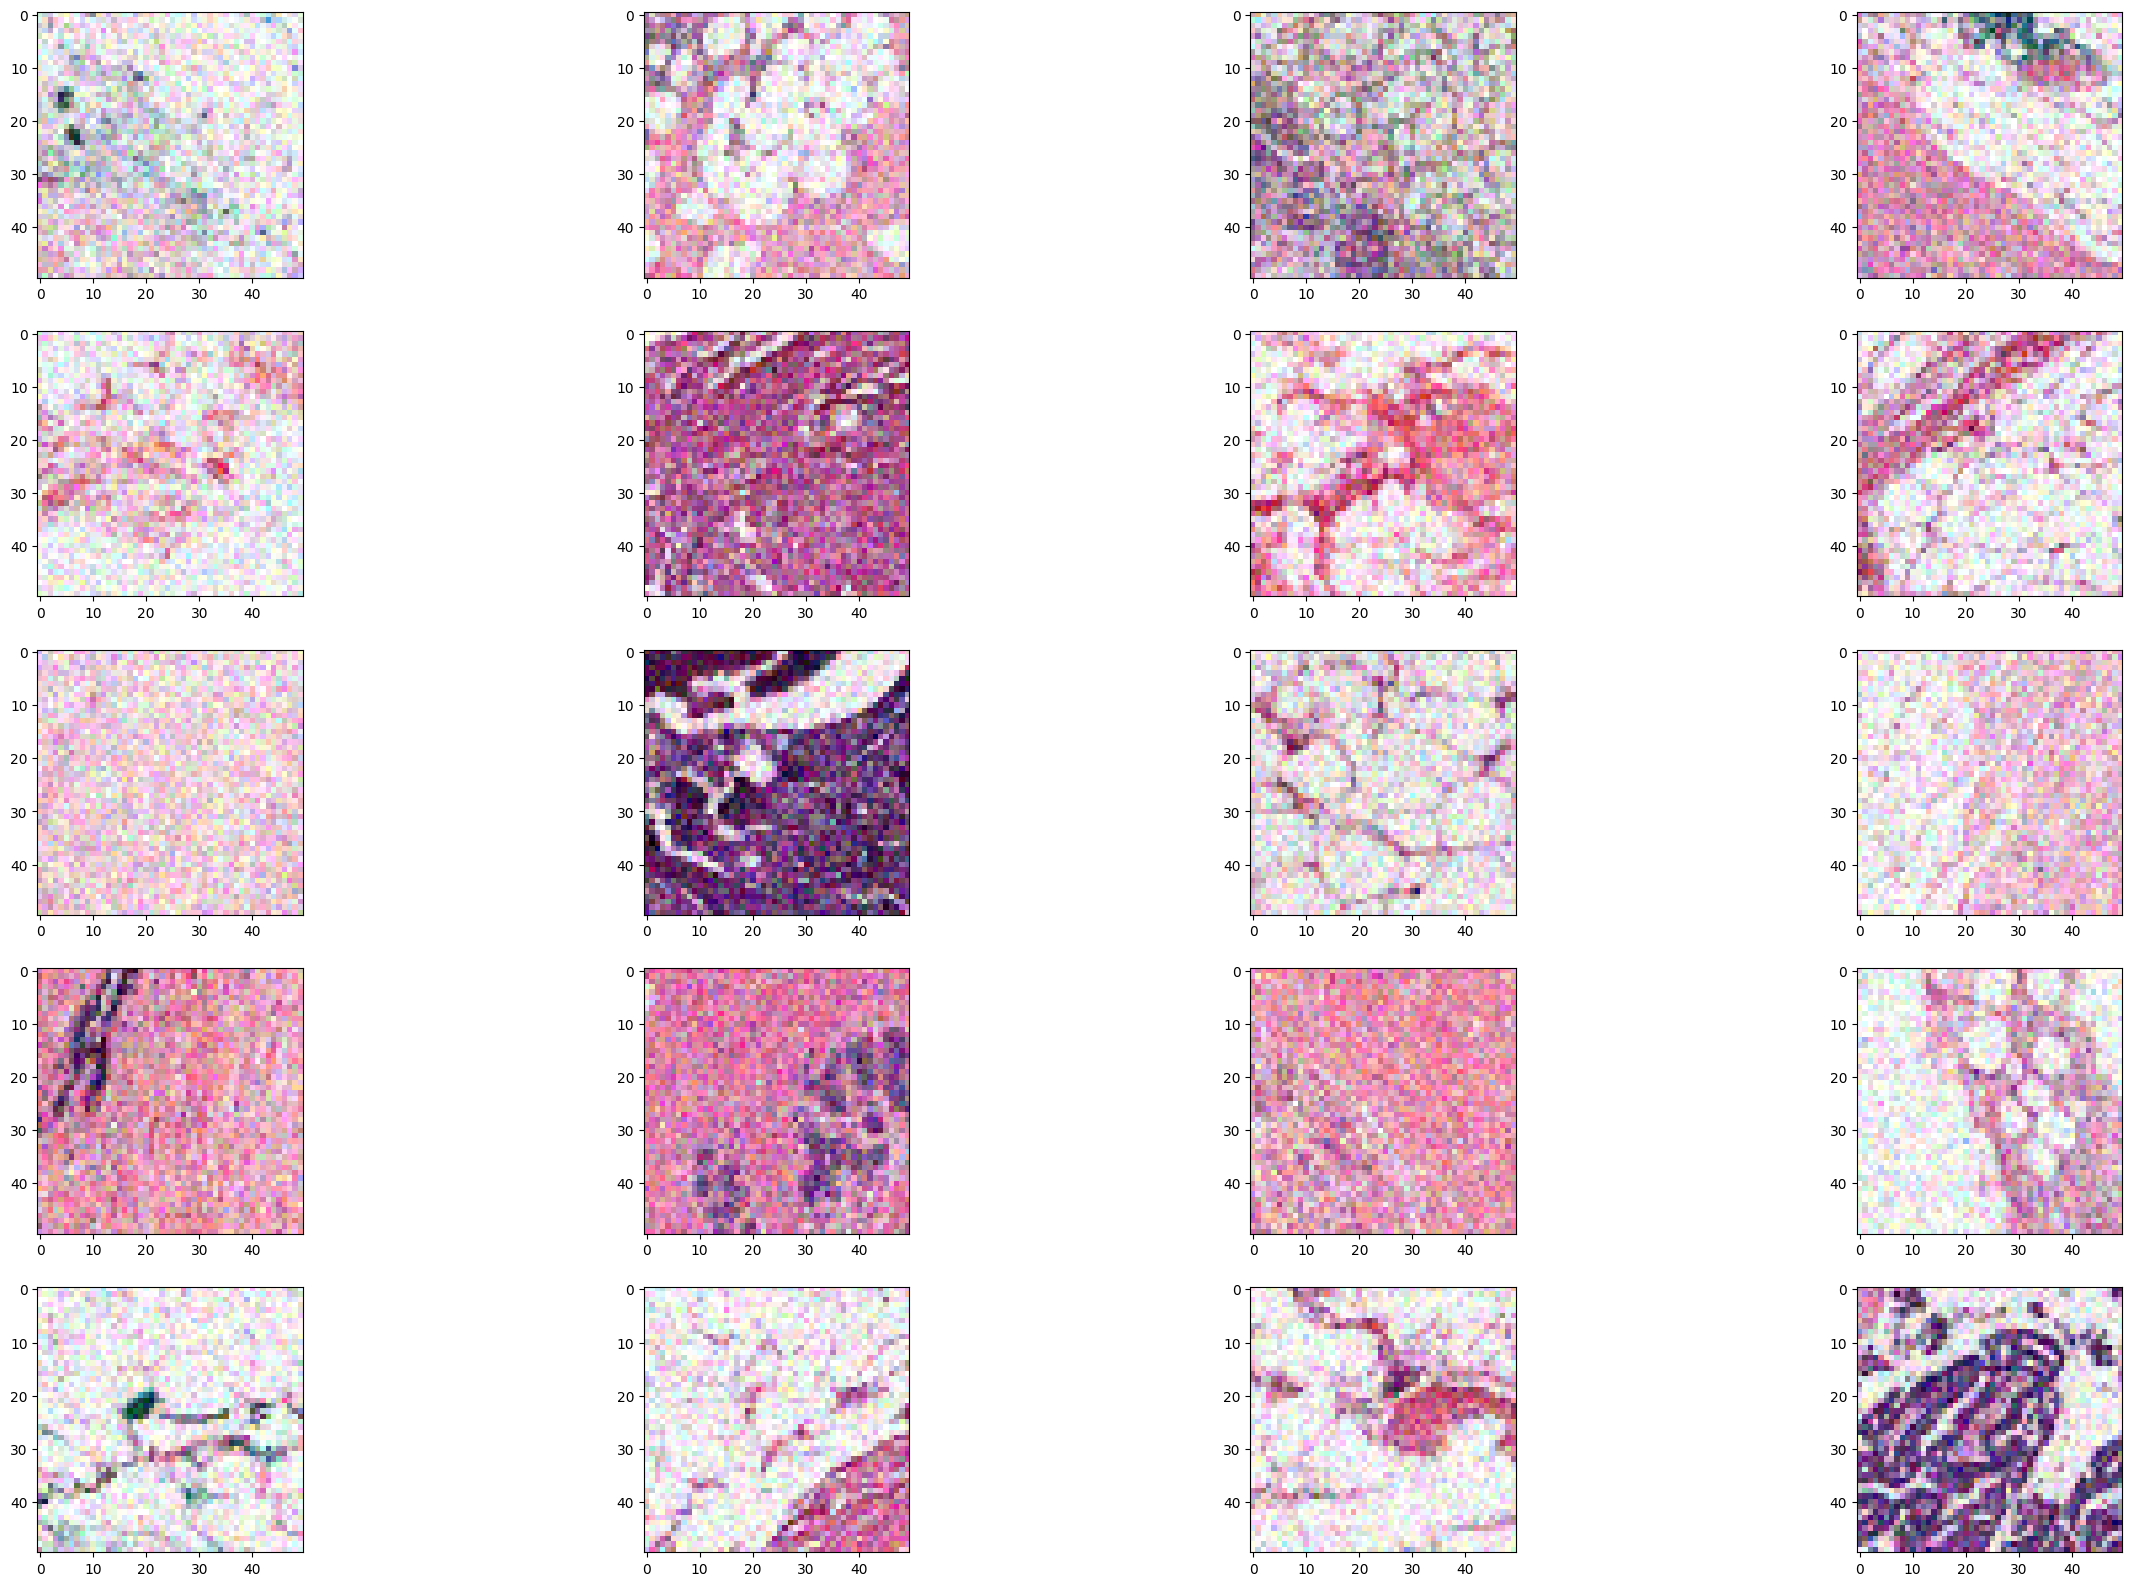

In [40]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the normal images that have been processed

In [41]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [42]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [43]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_processd,validation_data=test_generation_processd,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 117s 64ms/step - accuracy: 0.7152 - loss: 0.5706 - val_accuracy: 0.7715 - val_loss: 0.4914
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7674 - loss: 0.5035 - val_accuracy: 0.7695 - val_loss: 0.4789
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.7809 - loss: 0.4736 - val_accuracy: 0.7915 - val_loss: 0.4675
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.7913 - loss: 0.4567 - val_accuracy: 0.8045 - val_loss: 0.4463
Epoch 5/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8051 - loss: 0.4401 - val_accuracy: 0.7935 - val_loss: 0.4661
Epoch 6/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.8078 - loss: 0.4404 - val_accuracy: 0.7925 - val_loss: 0.4447
Epoch 7/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8067 - loss: 0.4326 - val_accuracy: 0.7825 - val_loss: 0.4662
Epoch 8/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8110 - loss: 0.4

### Second: the normal images

In [44]:
# os.mkdir( 'image_processing/normal')
# os.mkdir( 'image_processing/normal/model_tst') 
# os.mkdir( 'image_processing/normal/model_tst/trainig')
# os.mkdir( 'image_processing/normal/model_tst/testing')
# os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
# os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
# os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
# os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [45]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


In [46]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [47]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [48]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 106s 59ms/step - accuracy: 0.8215 - loss: 0.3950 - val_accuracy: 0.8020 - val_loss: 0.4852
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8282 - loss: 0.3894 - val_accuracy: 0.8020 - val_loss: 0.4720
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8377 - loss: 0.3687 - val_accuracy: 0.7885 - val_loss: 0.4968
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.8428 - loss: 0.3512 - val_accuracy: 0.7945 - val_loss: 0.5041


## conclusion : Normal images are the best in modeling 

> # Modeling

# Data Spliting & Generation

In [49]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0

In [50]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [51]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [52]:
# os.mkdir( 'train_dir')
# os.mkdir('test_dir')

In [53]:
# os.mkdir( 'train_dir/zeros')
# os.mkdir( 'train_dir/ones')

# os.mkdir( 'test_dir/zeros')
# os.mkdir( 'test_dir/ones')


In [54]:
train = data_train.image_id
test  = data_test.image_id

In [55]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [56]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)


In [57]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [58]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [59]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


># Model design

In [60]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [61]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
my_model.fit(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1069s 43ms/step - accuracy: 0.8084 - loss: 0.4360 - val_accuracy: 0.8395 - val_loss: 0.3683
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 701s 28ms/step - accuracy: 0.8362 - loss: 0.3848 - val_accuracy: 0.8251 - val_loss: 0.4002
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 707s 28ms/step - accuracy: 0.8413 - loss: 0.3706 - val_accuracy: 0.8476 - val_loss: 0.3662
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 441s 18ms/step - accuracy: 0.8473 - loss: 0.3574 - val_accuracy: 0.8535 - val_loss: 0.3408
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 355s 14ms/step - accuracy: 0.8496 - loss: 0.3533 - val_accuracy: 0.8527 - val_loss: 0.3431
Epoch 6/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 319s 13ms/step - accuracy: 0.8523 - loss: 0.3495 - val_accuracy: 0.8567 - val_loss: 0.3419


># Outputs and Outcomes

In [63]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0  0.822429  0.411382      0.839513  0.368267
1  0.837523  0.380209      0.825100  0.400213
2  0.843244  0.366531      0.847620  0.366226
3  0.847905  0.357016      0.853457  0.340824
4  0.850675  0.351696      0.852701  0.343103

<Axes: >

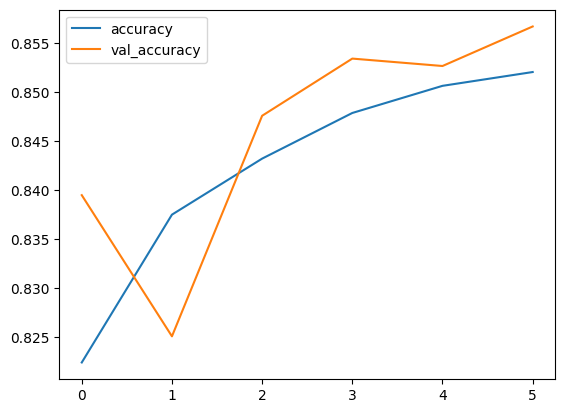

In [64]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

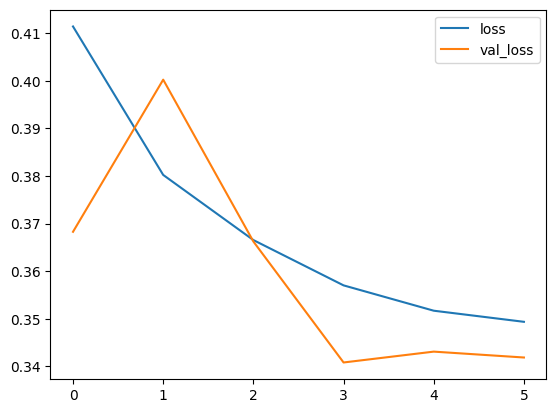

In [65]:
losse[['loss','val_loss']].plot()


In [66]:
val_loss, val_acc = \
my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8604 - loss: 0.3365
val_loss: 0.3418246805667877
val_acc: 0.8567361831665039


## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 85%
- over fitting is so small 
- We're ready to create APIs

> # Save &Loaded Model

In [67]:
model_json = my_model.to_json()

In [69]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model_weights.weights.h5")
print("Saved model architecture to disk")
print("Saved model weights to disk")

Saved model architecture to disk
Saved model weights to disk


In [70]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into the loaded model
loaded_model.load_weights("model_weights.weights.h5")
print("Loaded model from disk")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


> # APIs &  Web Localization

- we will use this class to connect the web app to the model

In [71]:
class Api_service :
    def __init__(self,img_file_path):
        self.img_file_path = img_file_path
    def prediction_function(self) :
        predict_generation = data_generation.flow_from_directory(
                                            self.img_file_path,
                                            target_size=(25,25),
                                            batch_size=10,
                                            class_mode='categorical')

        prediction = loaded_model.predict(predict_generation)
        has_cancer = 'The percentage of cancer : '+ str(round(prediction[0][0]*100,2)) + "%"
        has_no_cancer='Percentage of no cancer : ' + str(round(prediction[0][1]*100,2)) + '%'
        return has_cancer,has_no_cancer 


In [72]:
prediction = Api_service("image_processing/normal/model_tst/trainig")
x,y        = prediction.prediction_function()
print(x)
print(y)

Found 18000 images belonging to 2 classes.
   1/1800 ━━━━━━━━━━━━━━━━━━━━ 4:28 149ms/step

c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 172s 95ms/step
The percentage of cancer : 54.92%
Percentage of no cancer : 45.08%


#  *Finally we have finished*

-from [https://github.com/Ziad-o-Yusef/breast-cancer-detection-using-cnn-DL-] You can view the project in GitHub as well as web application files 
